This code does a thing

In [1]:
import rasterio
import numpy as np

Difference in file size for np.int8 vs np.int32:

Int8 COG size: 5.02 MB
Int32 COG size: 7.12 MB
Size ratio (int32/int8): 1.42x


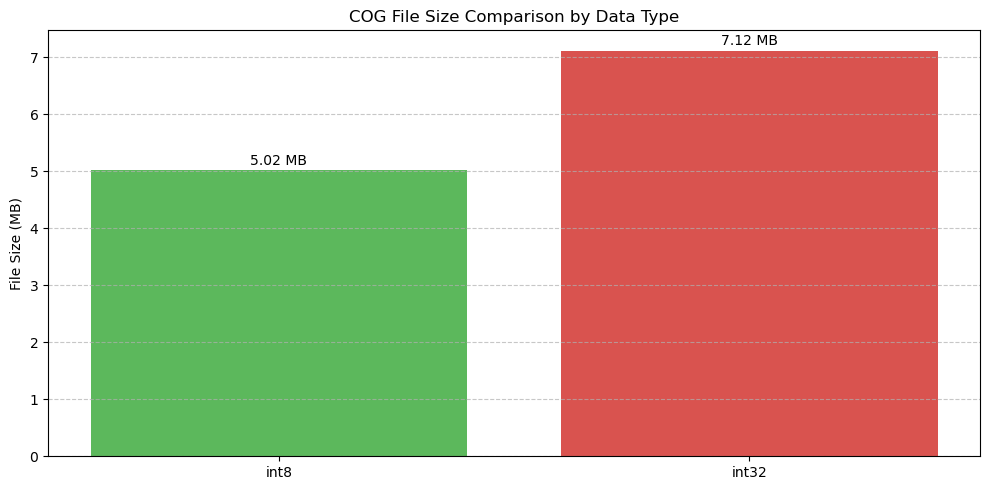

In [2]:
import os
from rasterio.transform import Affine
import matplotlib.pyplot as plt
from pathlib import Path
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles

# Set random seed for reproducibility
np.random.seed(42)

# Create a directory for our test files
output_dir = Path("tmp")
output_dir.mkdir(exist_ok=True)

# Create synthetic raster data (2000x2000 pixels)
rows, cols = 2000, 2000
data = np.random.randint(-128, 127, size=(rows, cols))

# Create a temporary GeoTIFF to convert to COG
temp_tif = output_dir / "temp.tif"

# Define a simple geotransform
transform = Affine(10, 0, 0, 0, -10, 0)  # 10m pixels


# Function to save as temporary GeoTIFF with specified dtype
def create_temp_tif(data, output_path, dtype):
    profile = {
        "driver": "GTiff",
        "height": data.shape[0],
        "width": data.shape[1],
        "count": 1,
        "dtype": dtype,
        "crs": "EPSG:4326",
        "transform": transform,
    }

    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(data.astype(dtype), 1)


# Function to convert to COG with rio-cogeo
def convert_to_cog(src_path, dst_path):
    cog_profile = cog_profiles.get("deflate")
    cog_translate(src_path, dst_path, cog_profile, quiet=True)
    return os.path.getsize(dst_path)


# Test with int8 data type
create_temp_tif(data, temp_tif, np.int8)
int8_path = output_dir / "raster_int8_cog.tif"
int8_size = convert_to_cog(temp_tif, int8_path)

# Test with int32 data type
create_temp_tif(data, temp_tif, np.int32)
int32_path = output_dir / "raster_int32_cog.tif"
int32_size = convert_to_cog(temp_tif, int32_path)

# Clean up temp file
if os.path.exists(temp_tif):
    os.remove(temp_tif)

# Report file sizes
print(f"Int8 COG size: {int8_size / 1024 / 1024:.2f} MB")
print(f"Int32 COG size: {int32_size / 1024 / 1024:.2f} MB")
print(f"Size ratio (int32/int8): {int32_size / int8_size:.2f}x")

# Plot comparison
labels = ["int8", "int32"]
sizes = [int8_size / 1024 / 1024, int32_size / 1024 / 1024]

plt.figure(figsize=(10, 5))
plt.bar(labels, sizes, color=["#5cb85c", "#d9534f"])
plt.ylabel("File Size (MB)")
plt.title("COG File Size Comparison by Data Type")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, size in enumerate(sizes):
    plt.text(i, size + 0.1, f"{size:.2f} MB", ha="center")

plt.tight_layout()
plt.show()

In [8]:
import geopandas as gpd

# Load the GeoPackage
gdf = gpd.read_file("tmp/jotrgeodata.gpkg", layer="JOTR_VegPolys")
print(gdf.head())

   Poly_ID MapUnit_ID                                       MapUnit_Name  \
0        1      10025  California Juniper / Blackbush Woodland Associ...   
1        2      27031  Creosote Bush - White Bursage Shrubland Associ...   
2        3      27034  Creosote Bush - White Bursage - White Rhatany ...   
3        4      27034  Creosote Bush - White Bursage - White Rhatany ...   
4        5      27045  Creosote Bush - White Bursage - Mojave Yucca S...   

      X_Centroid    Y_Centroid       Acres   Hectares  SHAPE_Length  \
0  576114.408632  3.758601e+06    4.703791   1.903557    544.379601   
1  592453.473849  3.750564e+06    2.077488   0.840730    401.724504   
2  656492.468889  3.765693e+06    3.485286   1.410445   1279.356090   
3  656720.121932  3.765627e+06    6.357370   2.572736   1995.108688   
4  609388.031467  3.733959e+06  235.720562  95.392727   6848.340282   

      SHAPE_Area                                           geometry  
0   19035.568321  MULTIPOLYGON (((576099.841 3

In [12]:
import numpy as np

# Create unique integers
unique_ids = gdf["MapUnit_ID"].unique()
id_map = {id_: i for i, id_ in enumerate(unique_ids)}

# Generate random colors or assign specific ones
color_map = {id_: np.random.randint(0, 256, size=3).tolist() for id_ in unique_ids}

# Add a new column for the integer values
gdf["int_id"] = gdf["MapUnit_ID"].map(id_map)

In [13]:
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# Define the output transform (raster bounds and resolution)
bounds = gdf.total_bounds
transform = from_bounds(
    *bounds, width=1000, height=1000
)  # Set desired width and height

# Create a generator for rasterize
shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf["int_id"]))

# Rasterize
output_raster = rasterize(
    shapes,
    out_shape=(1000, 1000),  # Match with the transformation settings
    fill=0,  # Default value for areas not covered by any geometry
    transform=transform,
    dtype=rasterio.uint8,
)

In [16]:
from rasterio.io import MemoryFile

# Save to an in-memory file first
with MemoryFile() as memfile:
    with memfile.open(
        driver="GTiff",
        height=output_raster.shape[0],
        width=output_raster.shape[1],
        count=1,  # Number of bands
        dtype=rasterio.uint8,
        crs=gdf.crs,  # Use the CRS from your source
        transform=transform,
    ) as dst:
        dst.write(output_raster, 1)

        # Assign a colormap (if you want to embed colors)
        dst.write_colormap(1, {i: tuple(color_map[uid]) for uid, i in id_map.items()})

    # Translate to a COG
    cog_translate(
        memfile.name,
        "output_cog.tif",
        cog_profiles.get("deflate"),
        nodata=0,
        overview_resampling="nearest",  # Pass 'nearest' as a string
    )

Reading input: /vsimem/47f10e1a-a7e8-4849-9dcc-3c4783212d91/47f10e1a-a7e8-4849-9dcc-3c4783212d91.tif

Adding overviews...
Updating dataset tags...
Writing output to: output_cog.tif
